In [1]:
import numpy as np
import scipy as sp
from scipy.stats import norm
import datetime as dt
from scipy.optimize import fmin_tnc, minimize
from scipy.interpolate import interp2d, RectBivariateSpline, SmoothBivariateSpline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
global callput, S0, K, T, r, maturity, div, divdate, mkt_quote

# Heston Model Class Definition—Explicit Finite Difference

In [59]:
class Heston_FiniteDifference(object):
    def __init__(self, callput, s0, K, T, r, v, kappa, 
                 sigma, theta, rho, ns, nv, nt, div=[], divdate=[], q=0):
        self.callput = callput
        self.s0 = s0
        self.K = float(K)
        self.T = T
        self.r = r 
        self.v = v
        self.kappa = kappa
        self.sigma = sigma
        self.theta = theta
        self.rho = rho
        self.div = div
        self.divdate = divdate
        self.ns = ns
        self.nv = nv
        self.nt = nt
        self.q = q
        
        tau = np.array([(t-dt.date.today()).days/365. for t in self.divdate])
        cumdiv = sum(self.div*np.exp(-tau*self.r))
        self.F = self.s0 - cumdiv
        
        self.s_max = self.F * 2.
        self.ds = self.s_max / float(self.ns)
        self.v_max = self.v * 2.
        self.dv = self.v_max / float(self.nv)
        self.dt = self.T / float(self.nt)
        
        delta_g = (np.arcsinh((self.s_max-self.K)*5./K) - np.arcsinh(-5.)) / self.ns
        g_i = [np.arcsinh(-5.) + i* delta_g for i in range(self.ns)]
        self.s_i = np.around(self.K + (self.K/5.)*np.sinh(g_i), 6)
        #self.s_i = np.array([0+self.ds*i for i in range(self.ns)])
        
        delta_h = np.arcsinh(self.K) / self.nv
        self.v_j = np.around(np.array([(self.v_max/self.K)*np.sinh(j * delta_h) 
                             for j in range(self.nv)]), 6)
        #self.v_j = np.array([0+self.dv*i for i in range(self.nv)])
        
        self.grid = np.array([np.repeat(np.maximum(self.callput*(s - self.K), 0), self.nv) 
                              for s in self.s_i])
        self.temp_grid = np.zeros(shape = (self.ns, self.nt))

    
    def _UpdateBoundary_(self):
        self.grid[0,:] = 0.
        self.grid[:,-1] = np.maximum(self.callput*(self.s_i - self.K), 0.)
        self.grid[-1,:] = np.maximum(self.callput*(self.s_max - self.K), 0.)
        self.temp_grid = self.grid

        for s in range(1, self.ns-1):
            der_v = (self.grid[s,1] - self.grid[s,0]) / (self.v_j[1] - self.v_j[0])
            der_s = (self.grid[s+1,0] - self.grid[s-1,0]) / (self.s_i[s+1] - self.s_i[s-1])
            RHS = -self.r * self.grid[s,0] + (self.r - self.q) * self.s_i[s] * der_s + \
                      self.kappa*self.theta*der_v
            self.grid[s,0] = RHS*self.dt + self.temp_grid[s,0]
            
        self.temp_grid = self.grid
        
    
    def _Traverse_(self):
        for s in range(1,self.ns-1):
            der_s = np.array([(self.temp_grid[s+1,v]-self.temp_grid[s-1,v]) / (self.s_i[s+1]-self.s_i[s-1])\
                             for v in range(1, self.nv-1)])
                          
            der_v = np.array([(self.temp_grid[s,v+1]-self.temp_grid[s,v-1]) / (self.v_j[v+1]-self.v_j[v-1]) \
                             for v in range(1, self.nv-1)])
            
            der_ss = np.array([((self.temp_grid[s+1,v]-self.temp_grid[s,v])/ (self.s_i[s+1]-self.s_i[s]) \
                             - (self.temp_grid[s,v]-self.temp_grid[s-1,v])/(self.s_i[s]-self.s_i[s-1])) \
                             /(self.s_i[s+1]-self.s_i[s]) for v in range(1, self.nv-1)])
                
            der_vv = np.array([((self.temp_grid[s,v+1]-self.temp_grid[s,v])/(self.v_j[v+1]-self.v_j[v]) \
                             - (self.temp_grid[s,v]- self.temp_grid[s,v-1])/(self.v_j[v]-self.v_j[v-1])) \
                             /(self.v_j[v+1]-self.v_j[v]) for v in range(1, self.nv-1)])
                
            der_sv = np.array([(self.temp_grid[s+1,v+1]-self.temp_grid[s-1,v+1]-self.temp_grid[s+1,v-1] \
                             + self.temp_grid[s-1,v-1]) /((self.s_i[s+1]\
                             -self.s_i[s-1])*(self.v_j[v+1]-self.v_j[v-1]))\
                             for v in range(1, self.nv-1)])
                       
            L = np.array(0.5*self.v_j[1:self.nv-1]*self.s_i[s]*self.s_i[s]*der_ss \
                             + 0.5*(self.sigma**2)*self.v_j[1:self.nv-1]*der_vv \
                             + self.rho*self.sigma*self.v_j[1:self.nv-1]*self.s_i[s]*der_sv \
                             + (self.r - self.q)*self.s_i[s] * der_s \
                             + self.kappa *(self.theta - self.v_j[1:self.nv-1]) * der_v \
                             - self.r*self.temp_grid[s,1:self.nv-1])           

            self.grid[s,1:self.nv-1] = L * self.dt + self.temp_grid[s,1:self.nv-1] 
        
        for s in range(self.ns):
            self.grid[s,:] = np.maximum(self.grid[s,:], self.callput*(self.s_i[s] - self.K))

                
    def FinalGrid(self):
        for t in range(self.nt):
            self._UpdateBoundary_()
            self._Traverse_()
        
    
    def price(self): 
        self.FinalGrid()
        #xx, yy = np.meshgrid(self.s_i, self.v_j)
        g = RectBivariateSpline(self.s_i, self.v_j, self.grid)
        return g(self.s0, self,v)
    
    

# Set Up Parameters

In [5]:
callput = 1
s0 = 106.35
K = 85.
maturity = dt.date(2019,7,19)
T = (maturity - dt.date.today()).days/365.
days_mat = (maturity - dt.date.today()).days
r = 0.024934
div = np.array([0.7172, 0.7172])
divdate = [dt.date(2019,4,19), dt.date(2019,7,19)]
mkt_quote = (20.9 + 21.1)/2.

#v = 0.2
#kappa = 0.1
#sigma = 0.1
#theta = 0.1
#rho = -0.9

# Calibration

In [8]:
# object func: params = [v, kappa, sigma, theta, rho]
def object_func(params):
    model = Heston_FiniteDifference(callput, s0, K, T, r, params[0], params[1], 
                                    params[2], params[3], params[4], ns, nv, nt, div, divdate)
    model.FinalGrid()
    xx, yy = np.meshgrid(model.s_i, model.v_j)
    f = interp2d(xx, yy, model.grid.T, kind="cubic")
    model_v = f(model.s0, model.v)
    #g = RectBivariateSpline(model.s_i, model.v_j, model.grid)
    #model_v = g(model.s0, model.v)
    return np.sqrt((model_v - mkt_quote)**2)

In [9]:
bounds = [(1e-8, 5.), (1e-8, 1.), (1e-8, 1.), (1e-8, 1.), (-1., 1.) ]
initial_guess = [0.02, 0.02, 0.02, 0.02, -0.2]

cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)

In [10]:
ns = 20
nv = 10
nt = 1000

# Very time consuming
opt_para = minimize(object_func, initial_guess, constraints=cons, 
                    method='COBYLA', options={'tol': 1e-6, 'maxiter': 1000, 'disp': True})

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=23,15 m=200 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=23,15 m=200 fp=0.000949 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds

/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=23,15 m=200 fp=0.000135 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=23,15 m=200 fp=0.000140 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/jinxiwen/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds

In [11]:
opt_para

     fun: 1.1219743853985165e-05
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 93
  status: 1
 success: True
       x: array([ 0.87805946,  0.01774595,  0.98989734,  0.02085169, -0.24326861])

In [20]:
#print "Calibrated Parameters ", '\n', '——————————————————————————'
print "v:", opt_para.x[0]
print "kappa:", opt_para.x[1]
print "sigma:", opt_para.x[2]
print "theta:", opt_para.x[3]
print "rho:", opt_para.x[4]
print "Stock Price:", s0
print "Interest Rate:", r
print "Strike Price:", K
print "Maturity:", T

v: 0.878059455792
kappa: 0.0177459528802
sigma: 0.989897337455
theta: 0.0208516861644
rho: -0.243268610974
Stock Price: 106.35
Interest Rate: 0.024934
Strike Price: 85.0
Maturity: 0.216438356164


# Option Pricing and Hedging

In [63]:
# Use optimized parameters
v = opt_para.x[0]
kappa = opt_para.x[1]
sigma = opt_para.x[2]
theta = opt_para.x[3]
rho = opt_para.x[4]
ns = 30
nv = 30
nt = 1500

option = Heston_FiniteDifference(callput, s0, K, T, r, v, kappa, 
                                 sigma, theta, rho, ns, nv, nt, div, divdate)
option.FinalGrid()
xx, yy = np.meshgrid(option.s_i, option.v_j)
f = interp2d(xx, yy, option.grid.T, kind="cubic")
g = RectBivariateSpline(option.s_i, option.v_j, option.grid)
print "Option price_g is:", float(g(option.s0, option.v))
print "Option price_f is:", float(f(option.s0, option.v))

Option price_g is: 30.5079706095
Option price_f is: 30.5084291517


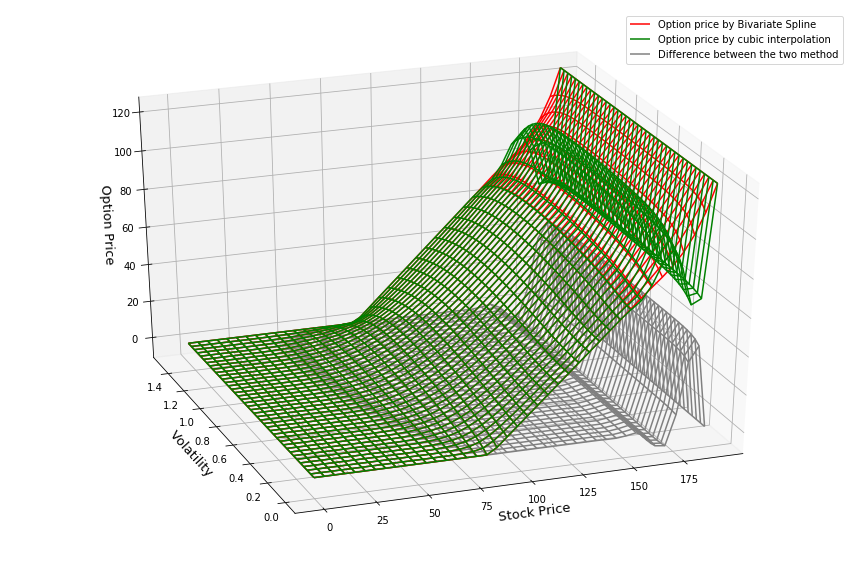

In [64]:
# difference between g and f interplotation algo
s = np.linspace(0, option.s_i[-1], 40)
v = np.linspace(0, option.v_j[-1], 40)
ss, vv = np.meshgrid(s, v)
xx, yy = np.meshgrid(option.s_i, option.v_j)

plt.figure(figsize = (15, 10), facecolor='white', edgecolor='black')
plt.rcParams['axes.facecolor'] = 'white'
ax = plt.axes(projection='3d')
ax.plot_wireframe(ss, vv, g(s,v).T, colors = 'red', label = 'Option price by Bivariate Spline')
ax.plot_wireframe(ss, vv, f(s,v), colors = 'green', label = 'Option price by cubic interpolation')
ax.plot_wireframe(ss,vv, g(s,v).T-f(s,v), color = 'grey', label = 'Difference between the two method')
ax.view_init(30, -110)
ax.set_xlabel('Stock Price', size=13)
ax.set_ylabel('Volatility', size=13)
ax.set_zlabel('Option Price', size=13)
plt.legend(loc='best')

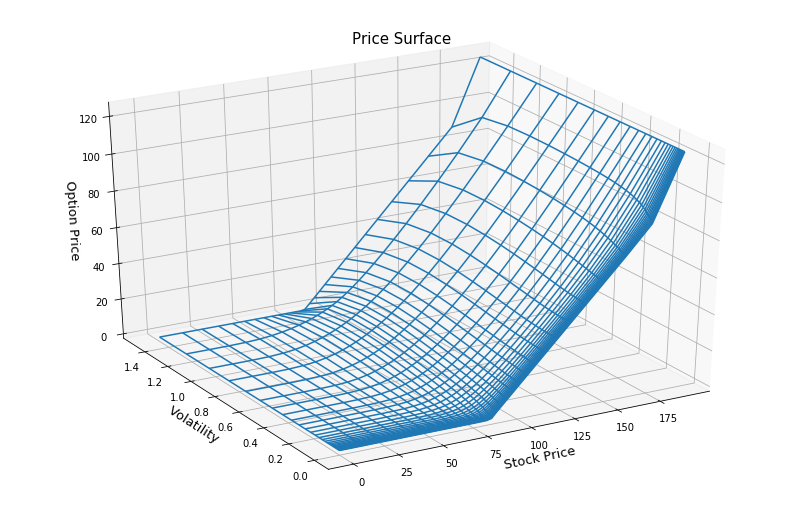

In [65]:
# option value surface 
xx, yy = np.meshgrid(option.s_i, option.v_j)
plt.figure(figsize = (14, 9), facecolor='white', edgecolor='black')
plt.rcParams['axes.facecolor'] = 'white'
ax = plt.axes(projection='3d')
ax.plot_wireframe(xx, yy, g(option.s_i, option.v_j).T, cmap='summer')
#ax.plot_wireframe(xx, yy, option.grid.T - f(option.s_i, option.v_j), colors='green')
ax.set_xlabel('Stock Price', size=13)
ax.set_ylabel('Volatility', size=13)
ax.set_zlabel('Option Price', size=13)
ax.set_title('Price Surface', size=15)
ax.view_init(30, -120)

In [66]:
# delta hedging
ds = 0.001
current_position = 2870.
Impvol = 0.2388

V1 = float(g(option.s0+ds, Impvol))
V2 = float(g(option.s0-ds, Impvol))
delta = (V1-V2)/(2*ds)
print "Delta of this option:", delta
print "Amount of stock to hedge:", delta*100*30
print "Rebalance shares to trade:", int(round(delta*100.*30., 4) - current_position)

Delta of this option: 0.895291988435
Amount of stock to hedge: 2685.87596531
Rebalance shares to trade: -184


In [67]:
# Plot delta surface 
VV1 = g(option.s_i+ds, option.v_j)
VV2 = g(option.s_i-ds, option.v_j)
deltas = (VV1-VV2).T/(2*ds)

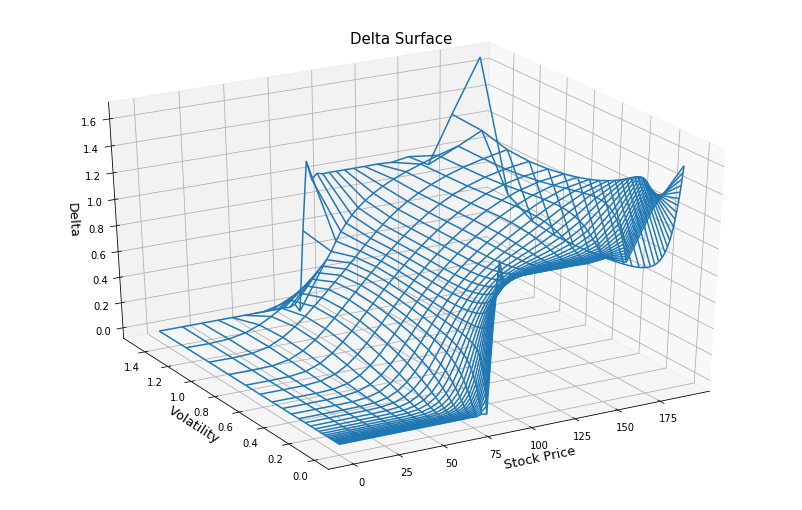

In [68]:
plt.figure(figsize = (14, 9), facecolor='white', edgecolor='black')
plt.rcParams['axes.facecolor'] = 'white'
ax = plt.axes(projection='3d')
ax.plot_wireframe(xx, yy, deltas, cmap='summer')
ax.set_xlabel('Stock Price', size=13)
ax.set_ylabel('Volatility',size=13)
ax.set_zlabel('Delta',size=13)
ax.set_title('Delta Surface',size=15)
ax.view_init(30, -120)

# Comments

We decided to use Explicit Finite Difference method because it has some advantages over other methods: 
* Relatively easy to approximate greeks.
* Easy to get the price and delta surface.
* Computation is relatively fast, and result is unique compared with Monte Carlo.

But the disadvantages of our method are also abvious:
* Very time consuming when calibrating.
* Very sensitive to parameters.
* Since the result is approximated by interpolation, the values on the boundary are highly unstable(as shown in the figures), it results from the boundary problem of interpolation.

If time permits, some improvements could be made to our work:
* Compare with Fourior Fast Transformation method, which we think could be the most fast and stable method.
* Modify our code to reduce the use of loops, which could increase the speed of calculation.
* Gamma hedge in addition to just delta hedge.
* Auto trade by using Interactive Broker's API.